In [1]:
import os
import glob
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/03 07:27:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setup Config

In [3]:
# set up config
model_train_date_str = "2009-01-01"
train_test_period_months = 108
oot_period_months = 12
train_test_ratio = 0.8

config = {}
config["model_train_date_str"] = model_train_date_str
config["train_test_period_months"] = train_test_period_months
config["oot_period_months"] =  oot_period_months
config["model_train_date"] =  datetime.strptime(model_train_date_str, "%Y-%m-%d")
config["oot_end_date"] = config["model_train_date"] - timedelta(days = 1)
config["oot_start_date"] =  config['model_train_date'] - relativedelta(months = oot_period_months)
config["train_test_end_date"] =  config["oot_start_date"] - timedelta(days = 1)
config["train_test_start_date"] =  config["oot_start_date"] - relativedelta(months = train_test_period_months)
config["train_test_ratio"] = train_test_ratio 


pprint.pprint(config)

{'model_train_date': datetime.datetime(2009, 1, 1, 0, 0),
 'model_train_date_str': '2009-01-01',
 'oot_end_date': datetime.datetime(2008, 12, 31, 0, 0),
 'oot_period_months': 12,
 'oot_start_date': datetime.datetime(2008, 1, 1, 0, 0),
 'train_test_end_date': datetime.datetime(2007, 12, 31, 0, 0),
 'train_test_period_months': 108,
 'train_test_ratio': 0.8,
 'train_test_start_date': datetime.datetime(1999, 1, 1, 0, 0)}


Label Store

In [4]:
# connect to label store - use Spark
# read all parquet directories
label_store_path = "datamart/gold/label_store/"
parquet_dirs = [os.path.join(label_store_path, d) for d in os.listdir(label_store_path) 
                if d.endswith('.parquet')]

print(f"Reading {len(parquet_dirs)} parquet directories with Spark...")

# read all parquet files using Spark
label_store_sdf = spark.read.parquet(*parquet_dirs)

print(f"Label store count: {label_store_sdf.count()}")
label_store_sdf.printSchema()
label_store_sdf.show(5)

Reading 120 parquet directories with Spark...


Label store count: 101766
root
 |-- encounter_id: integer (nullable = true)
 |-- label: integer (nullable = true)
 |-- snapshot_date: date (nullable = true)

+------------+-----+-------------+
|encounter_id|label|snapshot_date|
+------------+-----+-------------+
|     4679262|    0|   2000-08-01|
|     4680186|    0|   2000-08-02|
|     4682388|    0|   2000-08-03|
|     4728330|    0|   2000-08-04|
|     4729674|    0|   2000-08-05|
+------------+-----+-------------+
only showing top 5 rows



In [5]:
# filter labels by date range using Spark
labels_sdf = label_store_sdf.filter(
    (col("snapshot_date") >= config["train_test_start_date"]) & 
    (col("snapshot_date") <= config["oot_end_date"])
)

print(f"Filtered labels: {labels_sdf.count()} records")
print(f"Date range: {config['train_test_start_date']} to {config['oot_end_date']}")

[Stage 6:>                                                        (0 + 12) / 12]

Filtered labels: 101766 records
Date range: 1999-01-01 00:00:00 to 2008-12-31 00:00:00


Get features

In [6]:
# connect to feature store - use Spark
feature_store_path = "datamart/gold/feature_store/"
parquet_dirs = [os.path.join(feature_store_path, d) for d in os.listdir(feature_store_path) 
                if d.endswith('.parquet')]

print(f"Reading {len(parquet_dirs)} parquet directories with Spark...")

# read all parquet files using Spark
features_store_sdf = spark.read.parquet(*parquet_dirs)

print(f"Feature store count: {features_store_sdf.count()}")
features_store_sdf.printSchema()
features_store_sdf.show(5)

Reading 120 parquet directories with Spark...


Feature store count: 101766
root
 |-- encounter_id: integer (nullable = true)
 |-- race_AfricanAmerican: integer (nullable = true)
 |-- race_Caucasian: integer (nullable = true)
 |-- race_Asian: integer (nullable = true)
 |-- race_Hispanic: integer (nullable = true)
 |-- is_female: integer (nullable = true)
 |-- age_midpoint: integer (nullable = true)
 |-- admission_severity_score: integer (nullable = true)
 |-- admission_source_risk_score: integer (nullable = true)
 |-- poor_glucose_control: integer (nullable = true)
 |-- metformin_ord: integer (nullable = true)
 |-- insulin_ord: integer (nullable = true)
 |-- diabetesMed: integer (nullable = true)
 |-- severity_x_visits: integer (nullable = true)
 |-- medication_density: double (nullable = true)
 |-- diag_1_ord: integer (nullable = true)
 |-- diag_2_ord: integer (nullable = true)
 |-- diag_3_ord: integer (nullable = true)
 |-- snapshot_date: date (nullable = true)

+------------+--------------------+--------------+----------+--------

In [7]:
# filter features by date range using Spark
features_sdf = features_store_sdf.filter(
    (col("snapshot_date") >= config["train_test_start_date"]) & 
    (col("snapshot_date") <= config["oot_end_date"])
)

print(f"Filtered features: {features_sdf.count()} records")
print(f"Date range: {config['train_test_start_date']} to {config['oot_end_date']}")

[Stage 15:>                                                       (0 + 12) / 12]

Filtered features: 101766 records
Date range: 1999-01-01 00:00:00 to 2008-12-31 00:00:00


In [8]:
# join labels and features using Spark
data_sdf = labels_sdf.join(
    features_sdf, 
    on=["encounter_id", "snapshot_date"], 
    how="inner"
).toPandas()

print(f"Joined data count: {data_sdf.count()}")
data_sdf

Joined data count: encounter_id                   101766
snapshot_date                  101766
label                          101766
race_AfricanAmerican           101766
race_Caucasian                 101766
race_Asian                     101766
race_Hispanic                  101766
is_female                      101766
age_midpoint                   101766
admission_severity_score       101766
admission_source_risk_score    101766
poor_glucose_control           101766
metformin_ord                  101766
insulin_ord                    101766
diabetesMed                    101766
severity_x_visits              101766
medication_density             101766
diag_1_ord                     101766
diag_2_ord                     101766
diag_3_ord                     101766
dtype: int64


,encounter_id,snapshot_date,label,race_AfricanAmerican,race_Caucasian,race_Asian,race_Hispanic,is_female,age_midpoint,admission_severity_score,admission_source_risk_score,poor_glucose_control,metformin_ord,insulin_ord,diabetesMed,severity_x_visits,medication_density,diag_1_ord,diag_2_ord,diag_3_ord
0,15758256,2005-08-01,0,0,0,1,0,0,65,1,1,0,0,1,1,0,0.024145,5,5,0
1,15765702,2005-08-02,1,1,0,0,0,1,25,2,1,0,0,1,1,2,0.007470,2,8,10
2,15774312,2005-08-03,0,0,1,0,0,0,75,2,1,0,0,1,1,0,0.021053,0,0,0
3,15779280,2005-08-04,0,0,1,0,0,0,65,2,1,0,1,1,1,2,0.059341,0,0,0
4,15784284,2005-08-05,0,0,1,0,0,1,55,0,0,0,0,0,1,0,0.025424,7,10,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,403830632,1999-02-24,0,1,0,0,0,0,95,2,2,0,0,0,1,2,0.046154,10,10,10
101762,403830932,1999-02-25,0,0,1,0,0,1,25,3,2,0,0,0,0,7,0.007826,4,7,0
101763,403845980,1999-02-26,0,0,1,0,0,1,45,3,2,0,1,0,1,0,0.060606,10,8,10
101764,403846202,1999-02-27,0,0,1,0,0,0,65,3,2,1,1,2,1,0,0.045455,7,3,1


In [9]:
# split data into train - test - oot
oot_pdf = data_sdf[(data_sdf['snapshot_date'] >= config["oot_start_date"].date()) & (data_sdf['snapshot_date'] <= config["oot_end_date"].date())]
train_test_pdf = data_sdf[(data_sdf['snapshot_date'] >= config["train_test_start_date"].date()) & (data_sdf['snapshot_date'] <= config["train_test_end_date"].date())]

feature_cols = [c for c in train_test_pdf.columns if c not in ["encounter_id", "snapshot_date", "label"]]

X_oot = oot_pdf[feature_cols]
y_oot = oot_pdf["label"]
X_train, X_test, y_train, y_test = train_test_split(
    train_test_pdf[feature_cols], train_test_pdf["label"], 
    test_size= 1 - config["train_test_ratio"],
    random_state=88,     # Ensures reproducibility
    shuffle=True,        # Shuffle the data before splitting
    stratify=train_test_pdf["label"]           # Stratify based on the label column
)


print('X_train', X_train.shape[0])
print('X_test', X_test.shape[0])
print('X_oot', X_oot.shape[0])
print('y_train', y_train.shape[0], round(y_train.mean(),2))
print('y_test', y_test.shape[0], round(y_test.mean(),2))
print('y_oot', y_oot.shape[0], round(y_oot.mean(),2))

X_train

X_train 73507
X_test 18377
X_oot 9882
y_train 73507 0.11
y_test 18377 0.11
y_oot 9882 0.11


,race_AfricanAmerican,race_Caucasian,race_Asian,race_Hispanic,is_female,age_midpoint,admission_severity_score,admission_source_risk_score,poor_glucose_control,metformin_ord,insulin_ord,diabetesMed,severity_x_visits,medication_density,diag_1_ord,diag_2_ord,diag_3_ord
64497,0,1,0,0,1,65,1,1,0,0,2,1,0,0.083333,6,2,0
92020,0,1,0,0,0,75,2,1,0,0,-1,1,0,0.086183,0,0,0
58939,0,1,0,0,1,45,3,2,0,0,0,0,0,0.064103,3,10,2
50295,0,1,0,0,1,75,0,0,0,0,0,0,0,0.048682,0,1,7
101228,1,0,0,0,1,25,3,3,0,0,1,1,2,0.013774,2,3,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34324,0,1,0,0,0,85,3,2,0,1,0,1,2,0.034615,0,8,0
99464,0,1,0,0,1,75,3,2,0,0,0,0,0,0.150000,3,10,10
37345,0,1,0,0,1,55,1,3,0,0,0,0,0,0.026637,0,0,2
73202,0,1,0,0,1,45,3,2,0,1,2,1,0,0.013889,2,1,10


In [10]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Define a named function for log1p transformation ---
def log1p_transform(x):
    return np.log1p(x)



numeric_cols = [
    'age_midpoint','severity_x_visits', 'medication_density'
]

# Create a pipeline for numeric columns
numeric_pipeline = Pipeline(steps=[
    ('log', FunctionTransformer(log1p_transform)), 
    ('scaler', StandardScaler())
])

# Apply to numeric columns, keep the rest as is
scaler = ColumnTransformer(
    transformers=[('num', numeric_pipeline, numeric_cols)],
    remainder='passthrough'
)

transformer_stdscaler = scaler.fit(X_train)
X_train_processed = transformer_stdscaler.transform(X_train)
X_test_processed = transformer_stdscaler.transform(X_test)
X_oot_processed = transformer_stdscaler.transform(X_oot)

print('X_train_processed', X_train_processed.shape[0])
print('X_test_processed', X_test_processed.shape[0])
print('X_oot_processed', X_oot_processed.shape[0])

pd.DataFrame(X_train_processed)

X_train_processed 73507
X_test_processed 18377
X_oot_processed 9882


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.072197,-0.745774,0.406163,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,6.0,2.0,0.0
1,0.551448,-0.745774,0.445668,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0
2,-1.154182,-0.745774,0.136850,0.0,1.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,3.0,10.0,2.0
3,0.551448,-0.745774,-0.082650,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0
4,-3.092349,0.701293,-0.591680,1.0,0.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0,1.0,1.0,2.0,3.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73502,0.971370,0.701293,-0.285698,0.0,1.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,0.0,1.0,0.0,8.0,0.0
73503,0.551448,-0.745774,1.304115,0.0,1.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,3.0,10.0,10.0
73504,-0.485948,-0.745774,-0.402097,0.0,1.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
73505,-1.154182,-0.745774,-0.589977,0.0,1.0,0.0,0.0,1.0,3.0,2.0,0.0,1.0,2.0,1.0,2.0,1.0,10.0


### Logistic Regression Training

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
import pprint

# --------------------------------------------------------
# Define the Logistic Regression model
# --------------------------------------------------------
log_reg = LogisticRegression(
    solver='liblinear',  # works well for small/medium datasets & L1/L2 penalty
    random_state=88,
    max_iter=1000
)

# --------------------------------------------------------
# Define the hyperparameter search space
# --------------------------------------------------------
param_dist = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # inverse of regularization strength
    'class_weight': [None, 'balanced']
}

# --------------------------------------------------------
# Create a scorer based on AUC
# --------------------------------------------------------
auc_scorer = make_scorer(roc_auc_score)

# --------------------------------------------------------
# Randomized search with cross-validation
# --------------------------------------------------------
random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist,
    scoring=auc_scorer,
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=1  # avoid unicode error in Chinese path
)

# --------------------------------------------------------
# Fit the model on TRAIN data
# --------------------------------------------------------
random_search.fit(X_train_processed, y_train)

# --------------------------------------------------------
# Show best parameters and cross-val AUC
# --------------------------------------------------------
print("\nBest parameters found:")
pprint.pprint(random_search.best_params_)
print("Best cross-validation AUC score: ", random_search.best_score_)

# --------------------------------------------------------
# Evaluate best model on TRAIN / TEST / OOT
# --------------------------------------------------------
best_model = random_search.best_estimator_

# TRAIN
y_pred_train = best_model.predict_proba(X_train_processed)[:, 1]
train_auc = roc_auc_score(y_train, y_pred_train)

# TEST
y_pred_test = best_model.predict_proba(X_test_processed)[:, 1]
test_auc = roc_auc_score(y_test, y_pred_test)

# OOT
y_pred_oot = best_model.predict_proba(X_oot_processed)[:, 1]
oot_auc = roc_auc_score(y_oot, y_pred_oot)

# --------------------------------------------------------
# Print all AUC + GINI scores
# --------------------------------------------------------
print("\nAUC Scores:")
print(f"Train AUC: {train_auc:.4f}")
print(f"Test  AUC: {test_auc:.4f}")
print(f"OOT   AUC: {oot_auc:.4f}")

print("\nGINI Scores:")
print(f"Train GINI: {2*train_auc - 1:.4f}")
print(f"Test  GINI: {2*test_auc - 1:.4f}")
print(f"OOT   GINI: {2*oot_auc - 1:.4f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters found:
{'C': 10, 'class_weight': 'balanced', 'penalty': 'l1'}
Best cross-validation AUC score:  0.5834830273889623

AUC Scores:
Train AUC: 0.6131
Test  AUC: 0.6100
OOT   AUC: 0.6212

GINI Scores:
Train GINI: 0.2262
Test  GINI: 0.2199
OOT   GINI: 0.2424


In [12]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(feature_importance)


                        Feature  Coefficient
1                race_Caucasian     0.343430
13           medication_density     0.223942
6      admission_severity_score     0.088149
3                 race_Hispanic     0.082303
0          race_AfricanAmerican     0.062587
4                     is_female     0.056068
8          poor_glucose_control     0.026553
2                    race_Asian     0.021499
9                 metformin_ord     0.007195
16                   diag_3_ord     0.006682
15                   diag_2_ord     0.003081
7   admission_source_risk_score    -0.000094
12            severity_x_visits    -0.011885
14                   diag_1_ord    -0.014703
10                  insulin_ord    -0.044671
11                  diabetesMed    -0.145071
5                  age_midpoint    -0.171203


In [13]:
model_artefact = {}

model_artefact['model'] = best_model
model_artefact['model_version'] = "diabetes_LRmodel_"+config["model_train_date_str"].replace('-','_')
model_artefact['preprocessing_transformers'] = {}
model_artefact['preprocessing_transformers']['stdscaler'] = transformer_stdscaler
model_artefact['data_dates'] = config
model_artefact['data_stats'] = {}
model_artefact['data_stats']['X_train'] = X_train.shape[0]
model_artefact['data_stats']['X_test'] = X_test.shape[0]
model_artefact['data_stats']['X_oot'] = X_oot.shape[0]
model_artefact['data_stats']['y_train'] = round(y_train.mean(),2)
model_artefact['data_stats']['y_test'] = round(y_test.mean(),2)
model_artefact['data_stats']['y_oot'] = round(y_oot.mean(),2)
model_artefact['results'] = {}
model_artefact['results']['auc_train'] = train_auc
model_artefact['results']['auc_test'] = test_auc
model_artefact['results']['auc_oot'] = oot_auc
model_artefact['results']['gini_train'] = round(2*train_auc-1,3)
model_artefact['results']['gini_test'] = round(2*test_auc-1,3)
model_artefact['results']['gini_oot'] = round(2*oot_auc-1,3)
model_artefact['hp_params'] = random_search.best_params_


pprint.pprint(model_artefact)

# create model_bank dir
model_bank_directory = "model_bank/"

if not os.path.exists(model_bank_directory):
    os.makedirs(model_bank_directory)

# Full path to the file
file_path = os.path.join(model_bank_directory, model_artefact['model_version'] + '.pkl')

# Write the model to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(model_artefact, file)

print(f"Model saved to {file_path}")

{'data_dates': {'model_train_date': datetime.datetime(2009, 1, 1, 0, 0),
                'model_train_date_str': '2009-01-01',
                'oot_end_date': datetime.datetime(2008, 12, 31, 0, 0),
                'oot_period_months': 12,
                'oot_start_date': datetime.datetime(2008, 1, 1, 0, 0),
                'train_test_end_date': datetime.datetime(2007, 12, 31, 0, 0),
                'train_test_period_months': 108,
                'train_test_ratio': 0.8,
                'train_test_start_date': datetime.datetime(1999, 1, 1, 0, 0)},
 'data_stats': {'X_oot': 9882,
                'X_test': 18377,
                'X_train': 73507,
                'y_oot': np.float64(0.11),
                'y_test': np.float64(0.11),
                'y_train': np.float64(0.11)},
 'hp_params': {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1'},
 'model': LogisticRegression(C=10, class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=88, solver='liblinear

### Random Forrest Classifier Training

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
import pandas as pd
import pprint

# --------------------------------------------------------
# Define the Random Forest model
# --------------------------------------------------------
rf_model = RandomForestClassifier(
    random_state=88,
    n_jobs=-1
)

# --------------------------------------------------------
# Define the hyperparameter search space
# --------------------------------------------------------
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced']
}

# --------------------------------------------------------
# Create a scorer based on AUC
# --------------------------------------------------------
auc_scorer = make_scorer(roc_auc_score)

# --------------------------------------------------------
# Randomized search with cross-validation
# --------------------------------------------------------
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    scoring=auc_scorer,
    n_iter=15,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# --------------------------------------------------------
# Fit the model on TRAIN data
# --------------------------------------------------------
random_search.fit(X_train_processed, y_train)

# --------------------------------------------------------
# Show best parameters and cross-val AUC
# --------------------------------------------------------
print("\nBest parameters found:")
pprint.pprint(random_search.best_params_)
print("Best cross-validation AUC score: ", random_search.best_score_)

# --------------------------------------------------------
# Evaluate best model on TRAIN / TEST / OOT
# --------------------------------------------------------
best_model = random_search.best_estimator_

# TRAIN
y_pred_train = best_model.predict_proba(X_train_processed)[:, 1]
train_auc_rf = roc_auc_score(y_train, y_pred_train)

# TEST
y_pred_test = best_model.predict_proba(X_test_processed)[:, 1]
test_auc_rf = roc_auc_score(y_test, y_pred_test)

# OOT
y_pred_oot = best_model.predict_proba(X_oot_processed)[:, 1]
oot_auc_rf = roc_auc_score(y_oot, y_pred_oot)

# --------------------------------------------------------
# Print all AUC + GINI scores
# --------------------------------------------------------
print("\nAUC Scores:")
print(f"Train AUC: {train_auc_rf:.4f}")
print(f"Test  AUC: {test_auc_rf:.4f}")
print(f"OOT   AUC: {oot_auc_rf:.4f}")

print("\nGINI Scores:")
print(f"Train GINI: {2*train_auc_rf - 1:.4f}")
print(f"Test  GINI: {2*test_auc_rf - 1:.4f}")
print(f"OOT   GINI: {2*oot_auc_rf - 1:.4f}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best parameters found:
{'class_weight': 'balanced',
 'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 500}
Best cross-validation AUC score:  0.5870934050828418

AUC Scores:
Train AUC: 0.6342
Test  AUC: 0.6184
OOT   AUC: 0.6276

GINI Scores:
Train GINI: 0.2684
Test  GINI: 0.2369
OOT   GINI: 0.2552


In [15]:
# --------------------------------------------------------
# Feature Importance
# --------------------------------------------------------
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance:")
print(feature_importance.head(20))



Top Features by Importance:
                        Feature  Importance
1                race_Caucasian    0.677515
0          race_AfricanAmerican    0.097820
2                    race_Asian    0.088564
14                   diag_1_ord    0.035474
13           medication_density    0.019301
16                   diag_3_ord    0.019141
12            severity_x_visits    0.016108
8          poor_glucose_control    0.011159
11                  diabetesMed    0.010000
15                   diag_2_ord    0.007733
9                 metformin_ord    0.006787
10                  insulin_ord    0.002630
5                  age_midpoint    0.002137
6      admission_severity_score    0.001924
7   admission_source_risk_score    0.001374
3                 race_Hispanic    0.001357
4                     is_female    0.000976


In [16]:
model_artefact = {}

model_artefact['model'] = best_model
model_artefact['model_version'] = "diabetes_RFmodel_"+config["model_train_date_str"].replace('-','_')
model_artefact['preprocessing_transformers'] = {}
model_artefact['preprocessing_transformers']['stdscaler'] = transformer_stdscaler
model_artefact['data_dates'] = config
model_artefact['data_stats'] = {}
model_artefact['data_stats']['X_train'] = X_train.shape[0]
model_artefact['data_stats']['X_test'] = X_test.shape[0]
model_artefact['data_stats']['X_oot'] = X_oot.shape[0]
model_artefact['data_stats']['y_train'] = round(y_train.mean(),2)
model_artefact['data_stats']['y_test'] = round(y_test.mean(),2)
model_artefact['data_stats']['y_oot'] = round(y_oot.mean(),2)
model_artefact['results'] = {}
model_artefact['results']['auc_train'] = train_auc_rf
model_artefact['results']['auc_test'] = test_auc_rf
model_artefact['results']['auc_oot'] = oot_auc_rf
model_artefact['results']['gini_train'] = round(2*train_auc_rf-1,3)
model_artefact['results']['gini_test'] = round(2*test_auc_rf-1,3)
model_artefact['results']['gini_oot'] = round(2*oot_auc_rf-1,3)
model_artefact['hp_params'] = random_search.best_params_


pprint.pprint(model_artefact)

# create model_bank dir
model_bank_directory = "model_bank/"

if not os.path.exists(model_bank_directory):
    os.makedirs(model_bank_directory)

# Full path to the file
file_path = os.path.join(model_bank_directory, model_artefact['model_version'] + '.pkl')

# Write the model to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(model_artefact, file)

print(f"Model saved to {file_path}")

{'data_dates': {'model_train_date': datetime.datetime(2009, 1, 1, 0, 0),
                'model_train_date_str': '2009-01-01',
                'oot_end_date': datetime.datetime(2008, 12, 31, 0, 0),
                'oot_period_months': 12,
                'oot_start_date': datetime.datetime(2008, 1, 1, 0, 0),
                'train_test_end_date': datetime.datetime(2007, 12, 31, 0, 0),
                'train_test_period_months': 108,
                'train_test_ratio': 0.8,
                'train_test_start_date': datetime.datetime(1999, 1, 1, 0, 0)},
 'data_stats': {'X_oot': 9882,
                'X_test': 18377,
                'X_train': 73507,
                'y_oot': np.float64(0.11),
                'y_test': np.float64(0.11),
                'y_train': np.float64(0.11)},
 'hp_params': {'class_weight': 'balanced',
               'max_depth': 5,
               'max_features': None,
               'min_samples_leaf': 1,
               'min_samples_split': 10,
               'n_estim

### XGBoost Model Training


In [17]:
xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 3, 5, 8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3]
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    tree_method='hist'
)

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_params,
    scoring=auc_scorer,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1  # avoid unicode error in Chinese path
)

xgb_search.fit(X_train_processed, y_train)

print("\nXGBoost best params:")
pprint.pprint(xgb_search.best_params_)
print(f"CV AUC: {xgb_search.best_score_:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=300, scale_pos_weight=8, subsample=0.9; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=300, scale_pos_weight=8, subsample=0.9; total time=   1.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=300, scale_pos_weight=8, subsample=0.9; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, scale_pos_weight=5, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, scale_pos_weight=5, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=300, 

In [18]:
xgb_best = xgb_search.best_estimator_

y_pred_train_xgb = xgb_best.predict_proba(X_train_processed)[:, 1]
y_pred_test_xgb = xgb_best.predict_proba(X_test_processed)[:, 1]
y_pred_oot_xgb = xgb_best.predict_proba(X_oot_processed)[:, 1]

xgb_train_auc = roc_auc_score(y_train, y_pred_train_xgb)
xgb_test_auc = roc_auc_score(y_test, y_pred_test_xgb)
xgb_oot_auc = roc_auc_score(y_oot, y_pred_oot_xgb)

print("\n" + "="*50)
print("XGBoost Performance")
print("="*50)
print(f"\nAUC:")
print(f"  Train: {xgb_train_auc:.4f}")
print(f"  Test:  {xgb_test_auc:.4f}")
print(f"  OOT:   {xgb_oot_auc:.4f}")

print(f"\nGINI:")
print(f"  Train: {2*xgb_train_auc - 1:.4f}")
print(f"  Test:  {2*xgb_test_auc - 1:.4f}")
print(f"  OOT:   {2*xgb_oot_auc - 1:.4f}")

# additional metrics
from sklearn.metrics import average_precision_score, precision_recall_curve

pr_auc_test = average_precision_score(y_test, y_pred_test_xgb)
pr_auc_oot = average_precision_score(y_oot, y_pred_oot_xgb)

print(f"\nPR-AUC (better for imbalanced):")
print(f"  Test: {pr_auc_test:.4f}")
print(f"  OOT:  {pr_auc_oot:.4f}")



XGBoost Performance

AUC:
  Train: 0.6941
  Test:  0.6185
  OOT:   0.6310

GINI:
  Train: 0.3883
  Test:  0.2371
  OOT:   0.2620

PR-AUC (better for imbalanced):
  Test: 0.1727
  OOT:  0.1909



Top 20 Features:
                    feature  importance
             race_Caucasian    0.186903
         medication_density    0.069659
       race_AfricanAmerican    0.062174
                 diag_1_ord    0.054181
                diabetesMed    0.054118
                 race_Asian    0.053167
          severity_x_visits    0.052983
                  is_female    0.052649
               age_midpoint    0.052391
   admission_severity_score    0.049589
       poor_glucose_control    0.048804
              metformin_ord    0.047540
                 diag_3_ord    0.047512
                 diag_2_ord    0.046930
                insulin_ord    0.046357
              race_Hispanic    0.037544
admission_source_risk_score    0.037499


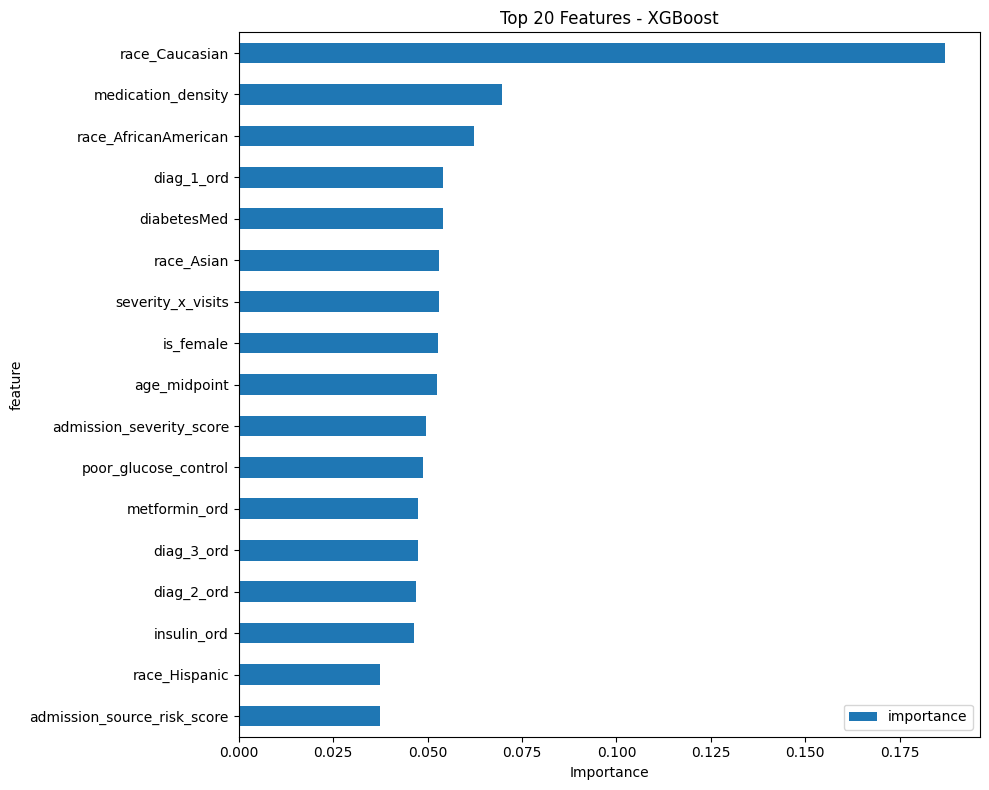

In [19]:
# feature importance
xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_best.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Features:")
print(xgb_importance.head(20).to_string(index=False))

# plot top features
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 20
xgb_importance.head(top_n).plot(x='feature', y='importance', kind='barh', ax=ax)
ax.set_xlabel('Importance')
ax.set_title(f'Top {top_n} Features - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [20]:
model_artefact = {}

model_artefact['model'] = xgb_best
model_artefact['model_version'] = "diabetes_XGBoostmodel_"+config["model_train_date_str"].replace('-','_')
model_artefact['preprocessing_transformers'] = {}
model_artefact['preprocessing_transformers']['stdscaler'] = transformer_stdscaler
model_artefact['data_dates'] = config
model_artefact['data_stats'] = {}
model_artefact['data_stats']['X_train'] = X_train.shape[0]
model_artefact['data_stats']['X_test'] = X_test.shape[0]
model_artefact['data_stats']['X_oot'] = X_oot.shape[0]
model_artefact['data_stats']['y_train'] = round(y_train.mean(),2)
model_artefact['data_stats']['y_test'] = round(y_test.mean(),2)
model_artefact['data_stats']['y_oot'] = round(y_oot.mean(),2)
model_artefact['results'] = {}
model_artefact['results']['auc_train'] = xgb_train_auc
model_artefact['results']['auc_test'] = xgb_test_auc
model_artefact['results']['auc_oot'] = xgb_oot_auc
model_artefact['results']['gini_train'] = round(2*xgb_train_auc-1,3)
model_artefact['results']['gini_test'] = round(2*xgb_test_auc-1,3)
model_artefact['results']['gini_oot'] = round(2*xgb_oot_auc-1,3)
model_artefact['hp_params'] = xgb_search.best_params_


pprint.pprint(model_artefact)

# create model_bank dir
model_bank_directory = "model_bank/"

if not os.path.exists(model_bank_directory):
    os.makedirs(model_bank_directory)

# Full path to the file
file_path = os.path.join(model_bank_directory, model_artefact['model_version'] + '.pkl')

# Write the model to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(model_artefact, file)

print(f"Model saved to {file_path}")

{'data_dates': {'model_train_date': datetime.datetime(2009, 1, 1, 0, 0),
                'model_train_date_str': '2009-01-01',
                'oot_end_date': datetime.datetime(2008, 12, 31, 0, 0),
                'oot_period_months': 12,
                'oot_start_date': datetime.datetime(2008, 1, 1, 0, 0),
                'train_test_end_date': datetime.datetime(2007, 12, 31, 0, 0),
                'train_test_period_months': 108,
                'train_test_ratio': 0.8,
                'train_test_start_date': datetime.datetime(1999, 1, 1, 0, 0)},
 'data_stats': {'X_oot': 9882,
                'X_test': 18377,
                'X_train': 73507,
                'y_oot': np.float64(0.11),
                'y_test': np.float64(0.11),
                'y_train': np.float64(0.11)},
 'hp_params': {'colsample_bytree': 0.8,
               'gamma': 0.3,
               'learning_rate': 0.05,
               'max_depth': 5,
               'min_child_weight': 3,
               'n_estimators': 200,


### LightGBM Model Training


In [21]:
# pip install lightgbm if needed
try:
    import lightgbm as lgb
    
    lgb_params = {
        'num_leaves': [15, 31, 63],
        'max_depth': [3, 5, 7, -1],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'min_child_samples': [5, 10, 20],
        'scale_pos_weight': [1, 3, 5, 8]
    }
    
    lgb_model = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        random_state=42,
        verbosity=-1
    )
    
    lgb_search = RandomizedSearchCV(
        estimator=lgb_model,
        param_distributions=lgb_params,
        scoring=auc_scorer,
        n_iter=20,
        cv=3,
        verbose=2,
        random_state=42,
        n_jobs=1  # avoid unicode error in Chinese path
    )
    
    lgb_search.fit(X_train_processed, y_train)
    
    print("\nLightGBM best params:")
    pprint.pprint(lgb_search.best_params_)
    print(f"CV AUC: {lgb_search.best_score_:.4f}")
    
except ImportError:
    print("LightGBM not installed, skipping...")


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, min_child_samples=10, n_estimators=100, num_leaves=63, scale_pos_weight=8, subsample=0.9; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, min_child_samples=10, n_estimators=100, num_leaves=63, scale_pos_weight=8, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, min_child_samples=10, n_estimators=100, num_leaves=63, scale_pos_weight=8, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_samples=10, n_estimators=300, num_leaves=63, scale_pos_weight=5, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_samples=10, n_estimators=300, num_leaves=63, scale_pos_weight=5, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_samples=10, n_estimators=300, num_leaves=63, scale_pos_weight=5, subsample=1.0; total time=   0.7s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=10, n_estimators=300, num_leaves=63, scale_pos_weight=1, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=10, n_estimators=300, num_leaves=63, scale_pos_weight=1, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=10, n_estimators=300, num_leaves=63, scale_pos_weight=1, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=5, n_estimators=100, num_leaves=15, scale_pos_weight=5, subsample=0.9; total time=   0.1s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=5, n_estimators=100, num_leaves=15, scale_pos_weight=5, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=5, n_estimators=100, num_leaves=15, scale_pos_weight=5, subsample=0.9; total time=   0.1s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_samples=20, n_estimators=200, num_leaves=31, scale_pos_weight=3, subsample=0.9; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_samples=20, n_estimators=200, num_leaves=31, scale_pos_weight=3, subsample=0.9; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_samples=20, n_estimators=200, num_leaves=31, scale_pos_weight=3, subsample=0.9; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, min_child_samples=20, n_estimators=100, num_leaves=15, scale_pos_weight=8, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, min_child_samples=20, n_estimators=100, num_leaves=15, scale_pos_weight=8, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, min_child_samples=20, n_estimators=100, num_leaves=15, scale_pos_weight=8, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=-1, min_child_samples=10, n_estimators=100, num_leaves=15, scale_pos_weight=1, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=-1, min_child_samples=10, n_estimators=100, num_leaves=15, scale_pos_weight=1, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=-1, min_child_samples=10, n_estimators=100, num_leaves=15, scale_pos_weight=1, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=63, scale_pos_weight=8, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=63, scale_pos_weight=8, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, min_child_samples=10, n_estimators=100, num_leaves=63, scale_pos_weight=8, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=10, n_estimators=300, num_leaves=63, scale_pos_weight=8, subsample=0.9; total time=   0.5s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=10, n_estimators=300, num_leaves=63, scale_pos_weight=8, subsample=0.9; total time=   0.5s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, min_child_samples=10, n_estimators=300, num_leaves=63, scale_pos_weight=8, subsample=0.9; total time=   0.5s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, min_child_samples=5, n_estimators=200, num_leaves=63, scale_pos_weight=8, subsample=0.9; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, min_child_samples=5, n_estimators=200, num_leaves=63, scale_pos_weight=8, subsample=0.9; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, min_child_samples=5, n_estimators=200, num_leaves=63, scale_pos_weight=8, subsample=0.9; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, min_child_samples=20, n_estimators=300, num_leaves=15, scale_pos_weight=5, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, min_child_samples=20, n_estimators=300, num_leaves=15, scale_pos_weight=5, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, min_child_samples=20, n_estimators=300, num_leaves=15, scale_pos_weight=5, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, min_child_samples=5, n_estimators=100, num_leaves=31, scale_pos_weight=8, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, min_child_samples=5, n_estimators=100, num_leaves=31, scale_pos_weight=8, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=-1, min_child_samples=5, n_estimators=100, num_leaves=31, scale_pos_weight=8, subsample=1.0; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_samples=5, n_estimators=300, num_leaves=31, scale_pos_weight=8, subsample=1.0; total time=   0.5s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_samples=5, n_estimators=300, num_leaves=31, scale_pos_weight=8, subsample=1.0; total time=   0.4s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, min_child_samples=5, n_estimators=300, num_leaves=31, scale_pos_weight=8, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_samples=20, n_estimators=100, num_leaves=15, scale_pos_weight=5, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_samples=20, n_estimators=100, num_leaves=15, scale_pos_weight=5, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, min_child_samples=20, n_estimators=100, num_leaves=15, scale_pos_weight=5, subsample=0.8; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_samples=5, n_estimators=200, num_leaves=63, scale_pos_weight=3, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_samples=5, n_estimators=200, num_leaves=63, scale_pos_weight=3, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, min_child_samples=5, n_estimators=200, num_leaves=63, scale_pos_weight=3, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_samples=10, n_estimators=100, num_leaves=31, scale_pos_weight=1, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_samples=10, n_estimators=100, num_leaves=31, scale_pos_weight=1, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, min_child_samples=10, n_estimators=100, num_leaves=31, scale_pos_weight=1, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_samples=10, n_estimators=300, num_leaves=63, scale_pos_weight=8, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_samples=10, n_estimators=300, num_leaves=63, scale_pos_weight=8, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_samples=10, n_estimators=300, num_leaves=63, scale_pos_weight=8, subsample=1.0; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=10, n_estimators=200, num_leaves=15, scale_pos_weight=1, subsample=0.9; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=10, n_estimators=200, num_leaves=15, scale_pos_weight=1, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, min_child_samples=10, n_estimators=200, num_leaves=15, scale_pos_weight=1, subsample=0.9; total time=   0.2s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=-1, min_child_samples=10, n_estimators=200, num_leaves=31, scale_pos_weight=8, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=-1, min_child_samples=10, n_estimators=200, num_leaves=31, scale_pos_weight=8, subsample=0.8; total time=   0.3s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=-1, min_child_samples=10, n_estimators=200, num_leaves=31, scale_pos_weight=8, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=10, n_estimators=100, num_leaves=31, scale_pos_weight=5, subsample=0.9; total time=   0.1s


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=10, n_estimators=100, num_leaves=31, scale_pos_weight=5, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=3, min_child_samples=10, n_estimators=100, num_leaves=31, scale_pos_weight=5, subsample=0.9; total time=   0.1s

LightGBM best params:
{'colsample_bytree': 0.9,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_samples': 20,
 'n_estimators': 100,
 'num_leaves': 15,
 'scale_pos_weight': 8,
 'subsample': 0.9}
CV AUC: 0.5902


In [22]:
if 'lgb_search' in locals():
    lgb_best = lgb_search.best_estimator_
    
    y_pred_train_lgb = lgb_best.predict_proba(X_train)[:, 1]
    y_pred_test_lgb = lgb_best.predict_proba(X_test)[:, 1]
    y_pred_oot_lgb = lgb_best.predict_proba(X_oot)[:, 1]
    
    lgb_train_auc = roc_auc_score(y_train, y_pred_train_lgb)
    lgb_test_auc = roc_auc_score(y_test, y_pred_test_lgb)
    lgb_oot_auc = roc_auc_score(y_oot, y_pred_oot_lgb)
    
    print("\n" + "="*50)
    print("LightGBM Performance")
    print("="*50)
    print(f"\nAUC:")
    print(f"  Train: {lgb_train_auc:.4f}")
    print(f"  Test:  {lgb_test_auc:.4f}")
    print(f"  OOT:   {lgb_oot_auc:.4f}")
    
    print(f"\nGINI:")
    print(f"  Train: {2*lgb_train_auc - 1:.4f}")
    print(f"  Test:  {2*lgb_test_auc - 1:.4f}")
    print(f"  OOT:   {2*lgb_oot_auc - 1:.4f}")



LightGBM Performance

AUC:
  Train: 0.5120
  Test:  0.5098
  OOT:   0.5021

GINI:
  Train: 0.0240
  Test:  0.0196
  OOT:   0.0041


In [23]:
model_artefact = {}

model_artefact['model'] = lgb_best
model_artefact['model_version'] = "diabetes_LightBGMmodel_"+config["model_train_date_str"].replace('-','_')
model_artefact['preprocessing_transformers'] = {}
model_artefact['preprocessing_transformers']['stdscaler'] = transformer_stdscaler
model_artefact['data_dates'] = config
model_artefact['data_stats'] = {}
model_artefact['data_stats']['X_train'] = X_train.shape[0]
model_artefact['data_stats']['X_test'] = X_test.shape[0]
model_artefact['data_stats']['X_oot'] = X_oot.shape[0]
model_artefact['data_stats']['y_train'] = round(y_train.mean(),2)
model_artefact['data_stats']['y_test'] = round(y_test.mean(),2)
model_artefact['data_stats']['y_oot'] = round(y_oot.mean(),2)
model_artefact['results'] = {}
model_artefact['results']['auc_train'] = lgb_train_auc
model_artefact['results']['auc_test'] = lgb_test_auc
model_artefact['results']['auc_oot'] = lgb_oot_auc
model_artefact['results']['gini_train'] = round(2*lgb_train_auc-1,3)
model_artefact['results']['gini_test'] = round(2*lgb_test_auc-1,3)
model_artefact['results']['gini_oot'] = round(2*lgb_oot_auc-1,3)
model_artefact['hp_params'] = lgb_search.best_params_


pprint.pprint(model_artefact)

# create model_bank dir
model_bank_directory = "model_bank/"

if not os.path.exists(model_bank_directory):
    os.makedirs(model_bank_directory)

# Full path to the file
file_path = os.path.join(model_bank_directory, model_artefact['model_version'] + '.pkl')

# Write the model to a pickle file
with open(file_path, 'wb') as file:
    pickle.dump(model_artefact, file)

print(f"Model saved to {file_path}")

{'data_dates': {'model_train_date': datetime.datetime(2009, 1, 1, 0, 0),
                'model_train_date_str': '2009-01-01',
                'oot_end_date': datetime.datetime(2008, 12, 31, 0, 0),
                'oot_period_months': 12,
                'oot_start_date': datetime.datetime(2008, 1, 1, 0, 0),
                'train_test_end_date': datetime.datetime(2007, 12, 31, 0, 0),
                'train_test_period_months': 108,
                'train_test_ratio': 0.8,
                'train_test_start_date': datetime.datetime(1999, 1, 1, 0, 0)},
 'data_stats': {'X_oot': 9882,
                'X_test': 18377,
                'X_train': 73507,
                'y_oot': np.float64(0.11),
                'y_test': np.float64(0.11),
                'y_train': np.float64(0.11)},
 'hp_params': {'colsample_bytree': 0.9,
               'learning_rate': 0.05,
               'max_depth': 5,
               'min_child_samples': 20,
               'n_estimators': 100,
               'num_leaves'

## Ensemble Learning

### Soft Voting Ensemble

In [24]:
from sklearn.ensemble import VotingClassifier
import pickle, os, pprint

# --------------------------------------------------------
# Load your trained models
# --------------------------------------------------------
# Load the model from the pickle file
XGB_model_version = "model_bank/"+"diabetes_XGBoostmodel_"+config["model_train_date_str"].replace('-','_')+".pkl"
LR_model_version = "model_bank/"+"diabetes_LRmodel_"+config["model_train_date_str"].replace('-','_')+".pkl"
RF_model_version = "model_bank/"+"diabetes_RFmodel_"+config["model_train_date_str"].replace('-','_')+".pkl"
with open(LR_model_version , 'rb') as file:
    logreg_model = pickle.load(file)
with open(XGB_model_version , 'rb') as file:
    xgb_model = pickle.load(file)
with open(RF_model_version , 'rb') as file:
    rf_model = pickle.load(file)

# --------------------------------------------------------
# Create a Voting Ensemble
# --------------------------------------------------------
voting_ensemble = VotingClassifier(
    estimators=[
        ('logreg', logreg_model['model']),
        ('rf', rf_model['model']),
        ('xgb', xgb_model['model'])
    ],
    voting='soft'  # 'soft' uses predicted probabilities
)

# Fit on training data
voting_ensemble.fit(X_train_processed, y_train)

# --------------------------------------------------------
# Evaluate Ensemble Performance
# --------------------------------------------------------
y_pred_train = voting_ensemble.predict_proba(X_train_processed)[:, 1]
y_pred_test = voting_ensemble.predict_proba(X_test_processed)[:, 1]
y_pred_oot = voting_ensemble.predict_proba(X_oot_processed)[:, 1]

train_auc_vot = roc_auc_score(y_train, y_pred_train)
test_auc_vot = roc_auc_score(y_test, y_pred_test)
oot_auc_vot = roc_auc_score(y_oot, y_pred_oot)

print("\nAUC Scores:")
print(f"Train AUC: {train_auc_vot:.4f}")
print(f"Test  AUC: {test_auc_vot:.4f}")
print(f"OOT   AUC: {oot_auc_vot:.4f}")

print("\nGINI Scores:")
print(f"Train GINI: {2*train_auc_vot - 1:.4f}")
print(f"Test  GINI: {2*test_auc_vot - 1:.4f}")
print(f"OOT   GINI: {2*oot_auc_vot - 1:.4f}")


AUC Scores:
Train AUC: 0.6577
Test  AUC: 0.6210
OOT   AUC: 0.6334

GINI Scores:
Train GINI: 0.3153
Test  GINI: 0.2420
OOT   GINI: 0.2668


In [25]:
# --------------------------------------------------------
# Save Model Artefact
# --------------------------------------------------------
model_artefact = {}
model_artefact['model'] = voting_ensemble
model_artefact['model_version'] = "diabetes_votingensemble_" + config["model_train_date_str"].replace('-', '_')
model_artefact['preprocessing_transformers'] = {'stdscaler': transformer_stdscaler}
model_artefact['data_dates'] = config
model_artefact['data_stats'] = {
    'X_train': X_train.shape[0],
    'X_test': X_test.shape[0],
    'X_oot': X_oot.shape[0],
    'y_train': round(y_train.mean(), 2),
    'y_test': round(y_test.mean(), 2),
    'y_oot': round(y_oot.mean(), 2)
}
model_artefact['results'] = {
    'auc_train': train_auc_vot,
    'auc_test': test_auc_vot,
    'auc_oot': oot_auc_vot,
    'gini_train': round(2*train_auc_vot - 1, 3),
    'gini_test': round(2*test_auc_vot - 1, 3),
    'gini_oot': round(2*oot_auc_vot - 1, 3)
}
model_artefact['hp_params'] = {
    'base_models': ['LogisticRegression', 'RandomForest', 'XGBoost'],
    'voting': 'soft'
}

pprint.pprint(model_artefact)

# Save
model_bank_directory = "model_bank/"
if not os.path.exists(model_bank_directory):
    os.makedirs(model_bank_directory)

file_path = os.path.join(model_bank_directory, model_artefact['model_version'] + '.pkl')
with open(file_path, 'wb') as file:
    pickle.dump(model_artefact, file)

print(f"Voting ensemble model saved to {file_path}")

{'data_dates': {'model_train_date': datetime.datetime(2009, 1, 1, 0, 0),
                'model_train_date_str': '2009-01-01',
                'oot_end_date': datetime.datetime(2008, 12, 31, 0, 0),
                'oot_period_months': 12,
                'oot_start_date': datetime.datetime(2008, 1, 1, 0, 0),
                'train_test_end_date': datetime.datetime(2007, 12, 31, 0, 0),
                'train_test_period_months': 108,
                'train_test_ratio': 0.8,
                'train_test_start_date': datetime.datetime(1999, 1, 1, 0, 0)},
 'data_stats': {'X_oot': 9882,
                'X_test': 18377,
                'X_train': 73507,
                'y_oot': np.float64(0.11),
                'y_test': np.float64(0.11),
                'y_train': np.float64(0.11)},
 'hp_params': {'base_models': ['LogisticRegression', 'RandomForest', 'XGBoost'],
               'voting': 'soft'},
 'model': VotingClassifier(estimators=[('logreg',
                              LogisticRegressio

### Stacking Ensemble

In [26]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# --------------------------------------------------------
# Load your trained models
# --------------------------------------------------------
# Load the model from the pickle file
XGB_model_version = "model_bank/"+"diabetes_XGBoostmodel_"+config["model_train_date_str"].replace('-','_')+".pkl"
LR_model_version = "model_bank/"+"diabetes_LRmodel_"+config["model_train_date_str"].replace('-','_')+".pkl"
RF_model_version = "model_bank/"+"diabetes_RFmodel_"+config["model_train_date_str"].replace('-','_')+".pkl"
with open(LR_model_version , 'rb') as file:
    logreg_model = pickle.load(file)
with open(XGB_model_version , 'rb') as file:
    xgb_model = pickle.load(file)
with open(RF_model_version , 'rb') as file:
    rf_model = pickle.load(file)

# Define the stacking ensemble
stacking_ensemble = StackingClassifier(
    estimators=[
        ('logreg', logreg_model["model"]),
        ('rf', rf_model["model"]),
        ('xgb', xgb_model["model"])
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=3,
    passthrough=False
)

stacking_ensemble.fit(X_train_processed, y_train)

# --------------------------------------------------------
# Evaluate Ensemble Performance
# --------------------------------------------------------
y_pred_train = stacking_ensemble.predict_proba(X_train_processed)[:, 1]
y_pred_test = stacking_ensemble.predict_proba(X_test_processed)[:, 1]
y_pred_oot = stacking_ensemble.predict_proba(X_oot_processed)[:, 1]

train_auc_stk = roc_auc_score(y_train, y_pred_train)
test_auc_stk = roc_auc_score(y_test, y_pred_test)
oot_auc_stk = roc_auc_score(y_oot, y_pred_oot)

print("\nAUC Scores:")
print(f"Train AUC: {train_auc_stk:.4f}")
print(f"Test  AUC: {test_auc_stk:.4f}")
print(f"OOT   AUC: {oot_auc_stk:.4f}")

print("\nGINI Scores:")
print(f"Train GINI: {2*train_auc_stk - 1:.4f}")
print(f"Test  GINI: {2*test_auc_stk - 1:.4f}")
print(f"OOT   GINI: {2*oot_auc_stk - 1:.4f}")



AUC Scores:
Train AUC: 0.6760
Test  AUC: 0.6209
OOT   AUC: 0.6334

GINI Scores:
Train GINI: 0.3520
Test  GINI: 0.2418
OOT   GINI: 0.2669


In [27]:
# --------------------------------------------------------
# Save Model Artefact
# --------------------------------------------------------
model_artefact = {}
model_artefact['model'] = stacking_ensemble
model_artefact['model_version'] = "diabetes_stackensemble_" + config["model_train_date_str"].replace('-', '_')
model_artefact['preprocessing_transformers'] = {'stdscaler': transformer_stdscaler}
model_artefact['data_dates'] = config
model_artefact['data_stats'] = {
    'X_train': X_train.shape[0],
    'X_test': X_test.shape[0],
    'X_oot': X_oot.shape[0],
    'y_train': round(y_train.mean(), 2),
    'y_test': round(y_test.mean(), 2),
    'y_oot': round(y_oot.mean(), 2)
}
model_artefact['results'] = {
    'auc_train': train_auc_stk,
    'auc_test': test_auc_stk,
    'auc_oot': oot_auc_stk,
    'gini_train': round(2*train_auc_stk - 1, 3),
    'gini_test': round(2*test_auc_stk - 1, 3),
    'gini_oot': round(2*oot_auc_stk - 1, 3)
}
model_artefact['hp_params'] = {
    'base_models': ['LogisticRegression', 'RandomForest', 'XGBoost'],
    'final_estimator': 'LogisticRegression'
}

pprint.pprint(model_artefact)

# Save
model_bank_directory = "model_bank/"
if not os.path.exists(model_bank_directory):
    os.makedirs(model_bank_directory)

file_path = os.path.join(model_bank_directory, model_artefact['model_version'] + '.pkl')
with open(file_path, 'wb') as file:
    pickle.dump(model_artefact, file)

print(f"Voting ensemble model saved to {file_path}")

{'data_dates': {'model_train_date': datetime.datetime(2009, 1, 1, 0, 0),
                'model_train_date_str': '2009-01-01',
                'oot_end_date': datetime.datetime(2008, 12, 31, 0, 0),
                'oot_period_months': 12,
                'oot_start_date': datetime.datetime(2008, 1, 1, 0, 0),
                'train_test_end_date': datetime.datetime(2007, 12, 31, 0, 0),
                'train_test_period_months': 108,
                'train_test_ratio': 0.8,
                'train_test_start_date': datetime.datetime(1999, 1, 1, 0, 0)},
 'data_stats': {'X_oot': 9882,
                'X_test': 18377,
                'X_train': 73507,
                'y_oot': np.float64(0.11),
                'y_test': np.float64(0.11),
                'y_train': np.float64(0.11)},
 'hp_params': {'base_models': ['LogisticRegression', 'RandomForest', 'XGBoost'],
               'final_estimator': 'LogisticRegression'},
 'model': StackingClassifier(cv=3,
                   estimators=[('logreg

### Model Comparison


In [28]:
comparison = pd.DataFrame({
    'Model': ['Logistic Regression',"Random Forest", 'XGBoost', "Voting Ensemble", "Stacking Ensemble"],
    'Train_AUC': [train_auc,train_auc_rf, xgb_train_auc,train_auc_vot,train_auc_stk],
    'Test_AUC': [test_auc,test_auc_rf, xgb_test_auc, test_auc_vot, test_auc_stk],
    'OOT_AUC': [oot_auc,oot_auc_rf, xgb_oot_auc, oot_auc_vot, oot_auc_stk],
    'Train_GINI': [2*train_auc-1,2*train_auc_rf-1, 2*xgb_train_auc-1, 2*train_auc_vot-1, 2*train_auc_stk-1],
    'Test_GINI': [2*test_auc-1, 2*test_auc_rf-1,2*xgb_test_auc-1, 2*test_auc_vot-1, 2*test_auc_stk-1],
    'OOT_GINI': [2*oot_auc-1,2*oot_auc_rf-1 ,2*xgb_oot_auc-1, 2*oot_auc_vot-1, 2*oot_auc_stk-1]
})

if 'lgb_oot_auc' in locals():
    comparison = pd.concat([comparison, pd.DataFrame({
        'Model': ['LightGBM'],
        'Train_AUC': [lgb_train_auc],
        'Test_AUC': [lgb_test_auc],
        'OOT_AUC': [lgb_oot_auc],
        'Train_GINI': [2*lgb_train_auc-1],
        'Test_GINI': [2*lgb_test_auc-1],
        'OOT_GINI': [2*lgb_oot_auc-1]
    })], ignore_index=True)

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(comparison.to_string(index=False))

# identify best model
best_idx = comparison['OOT_GINI'].idxmax()
print(f"\nBest model by OOT GINI: {comparison.loc[best_idx, 'Model']}")
print(f"OOT GINI: {comparison.loc[best_idx, 'OOT_GINI']:.4f}")



MODEL COMPARISON
              Model  Train_AUC  Test_AUC  OOT_AUC  Train_GINI  Test_GINI  OOT_GINI
Logistic Regression   0.613081  0.609971 0.621208    0.226161   0.219941  0.242416
      Random Forest   0.634191  0.618444 0.627624    0.268381   0.236889  0.255248
            XGBoost   0.694146  0.618542 0.630988    0.388291   0.237084  0.261976
    Voting Ensemble   0.657657  0.621018 0.633399    0.315314   0.242037  0.266797
  Stacking Ensemble   0.675990  0.620924 0.633445    0.351979   0.241848  0.266891
           LightGBM   0.511981  0.509807 0.502073    0.023962   0.019613  0.004147

Best model by OOT GINI: Stacking Ensemble
OOT GINI: 0.2669


### Drift Detection


In [29]:
# # check for distribution drift between train and OOT
# from scipy.stats import ks_2samp

# drift_results = []

# for feat in feature_cols:
#     if feat in X_train.columns and feat in X_oot.columns:
#         train_vals = X_train[feat].dropna()
#         oot_vals = X_oot[feat].dropna()
        
#         # KS test
#         ks_stat, p_value = ks_2samp(train_vals, oot_vals)
        
#         # PSI calculation
#         def calc_psi(expected, actual, bins=10):
#             breakpoints = np.linspace(0, 100, bins+1)
#             expected_percents = np.percentile(expected, breakpoints)
            
#             expected_counts = np.histogram(expected, bins=expected_percents)[0]
#             actual_counts = np.histogram(actual, bins=expected_percents)[0]
            
#             expected_percents = expected_counts / len(expected)
#             actual_percents = actual_counts / len(actual)
            
#             # avoid log(0)
#             expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
#             actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)
            
#             psi = np.sum((actual_percents - expected_percents) * np.log(actual_percents / expected_percents))
#             return psi
        
#         try:
#             psi = calc_psi(train_vals, oot_vals)
#         except:
#             psi = np.nan
        
#         drift_results.append({
#             'feature': feat,
#             'ks_stat': ks_stat,
#             'p_value': p_value,
#             'psi': psi,
#             'drift_detected': (p_value < 0.05) or (psi > 0.1)
#         })

# drift_df = pd.DataFrame(drift_results).sort_values('psi', ascending=False)

# print("Features with Drift (PSI > 0.1 or KS p-value < 0.05):")
# print(drift_df[drift_df['drift_detected']].head(15).to_string(index=False))

# drift_count = drift_df['drift_detected'].sum()
# print(f"\nTotal features with drift: {drift_count} / {len(feature_cols)} ({drift_count/len(feature_cols)*100:.1f}%)")


In [30]:
# # prediction distribution drift
# pred_train_dist = np.histogram(y_pred_train_xgb, bins=20, range=(0,1))[0] / len(y_pred_train_xgb)
# pred_test_dist = np.histogram(y_pred_test_xgb, bins=20, range=(0,1))[0] / len(y_pred_test_xgb)
# pred_oot_dist = np.histogram(y_pred_oot_xgb, bins=20, range=(0,1))[0] / len(y_pred_oot_xgb)

# fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# axes[0].hist(y_pred_train_xgb, bins=30, alpha=0.7, edgecolor='black')
# axes[0].set_title('Train Predictions')
# axes[0].set_xlabel('Predicted Probability')
# axes[0].axvline(y_pred_train_xgb.mean(), color='r', linestyle='--', label=f'mean: {y_pred_train_xgb.mean():.3f}')
# axes[0].legend()

# axes[1].hist(y_pred_test_xgb, bins=30, alpha=0.7, edgecolor='black')
# axes[1].set_title('Test Predictions')
# axes[1].set_xlabel('Predicted Probability')
# axes[1].axvline(y_pred_test_xgb.mean(), color='r', linestyle='--', label=f'mean: {y_pred_test_xgb.mean():.3f}')
# axes[1].legend()

# axes[2].hist(y_pred_oot_xgb, bins=30, alpha=0.7, edgecolor='black')
# axes[2].set_title('OOT Predictions')
# axes[2].set_xlabel('Predicted Probability')
# axes[2].axvline(y_pred_oot_xgb.mean(), color='r', linestyle='--', label=f'mean: {y_pred_oot_xgb.mean():.3f}')
# axes[2].legend()

# plt.tight_layout()
# plt.show()

# print(f"\nPrediction mean shift:")
# print(f"  Train: {y_pred_train_xgb.mean():.4f}")
# print(f"  Test:  {y_pred_test_xgb.mean():.4f}")
# print(f"  OOT:   {y_pred_oot_xgb.mean():.4f}")
# print(f"  Shift (Train→OOT): {abs(y_pred_oot_xgb.mean() - y_pred_train_xgb.mean()):.4f}")


### Save Model and Artifacts


In [31]:
# # save best XGBoost model
# model_filename = f'xgboost_model_{config["model_train_date_str"]}.pkl'
# with open(model_filename, 'wb') as f:
#     pickle.dump(xgb_best, f)

# print(f"Model saved: {model_filename}")

# # save feature list
# with open('feature_columns.json', 'w') as f:
#     json.dump(feature_cols, f, indent=2)

# # save model metadata
# metadata = {
#     'model_type': 'XGBoost',
#     'train_date': config["model_train_date_str"],
#     'train_period': f'{config["train_test_start_date"]} to {config["train_test_end_date"]}',
#     'oot_period': f'{config["oot_start_date"]} to {config["oot_end_date"]}',
#     'n_features': len(feature_cols),
#     'train_samples': len(X_train),
#     'test_samples': len(X_test),
#     'oot_samples': len(X_oot),
#     'train_auc': float(xgb_train_auc),
#     'test_auc': float(xgb_test_auc),
#     'oot_auc': float(xgb_oot_auc),
#     'train_gini': float(2*xgb_train_auc - 1),
#     'test_gini': float(2*xgb_test_auc - 1),
#     'oot_gini': float(2*xgb_oot_auc - 1),
#     'best_params': xgb_search.best_params_
# }

# with open('model_metadata.json', 'w') as f:
#     json.dump(metadata, f, indent=2, default=str)

# print("Metadata saved: model_metadata.json")

# # save drift report
# drift_df.to_csv('drift_report.csv', index=False)
# print("Drift report saved: drift_report.csv")


In [32]:
# # save model to model bank with versioning
# import os
# import pickle
# import json
# from datetime import datetime

# # check if model exists
# if 'xgb_best' not in locals():
#     raise ValueError("❌ xgb_best not found. Please run Cell 25 (XGBoost Training) first!")

# # create model bank directory
# model_bank_dir = "model_bank"
# os.makedirs(model_bank_dir, exist_ok=True)

# # generate version timestamp
# version_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# model_version = f"v_{version_timestamp}"

# # create version subdirectory
# version_dir = os.path.join(model_bank_dir, model_version)
# os.makedirs(version_dir, exist_ok=True)

# # save XGBoost model
# model_path = os.path.join(version_dir, "xgboost_model.pkl")
# with open(model_path, 'wb') as f:
#     pickle.dump(xgb_best, f)

# # save LightGBM model if available
# if 'lgb_best' in locals():
#     lgb_model_path = os.path.join(version_dir, "lightgbm_model.pkl")
#     with open(lgb_model_path, 'wb') as f:
#         pickle.dump(lgb_best, f)

# # save feature columns
# feature_path = os.path.join(version_dir, "feature_columns.json")
# with open(feature_path, 'w') as f:
#     json.dump(feature_cols, f, indent=2)

# # save comprehensive model metadata
# model_bank_metadata = {
#     'version': model_version,
#     'created_at': version_timestamp,
#     'model_type': 'XGBoost',
#     'training_config': {
#         'train_date': config["model_train_date_str"],
#         'train_period_start': str(config["train_test_start_date"]),
#         'train_period_end': str(config["train_test_end_date"]),
#         'oot_period_start': str(config["oot_start_date"]),
#         'oot_period_end': str(config["oot_end_date"]),
#         'train_test_ratio': config["train_test_ratio"]
#     },
#     'data_info': {
#         'n_features': len(feature_cols),
#         'train_samples': int(len(X_train)),
#         'test_samples': int(len(X_test)),
#         'oot_samples': int(len(X_oot)),
#         'train_positive_rate': float(y_train.mean()),
#         'test_positive_rate': float(y_test.mean()),
#         'oot_positive_rate': float(y_oot.mean())
#     },
#     'performance': {
#         'xgboost': {
#             'train_auc': float(xgb_train_auc),
#             'test_auc': float(xgb_test_auc),
#             'oot_auc': float(xgb_oot_auc),
#             'train_gini': float(2*xgb_train_auc - 1),
#             'test_gini': float(2*xgb_test_auc - 1),
#             'oot_gini': float(2*xgb_oot_auc - 1),
#             'best_params': xgb_search.best_params_
#         }
#     },
#     'feature_engineering': {
#         'diagnosis_features': True,
#         'high_risk_categories': ['circulatory', 'diabetes', 'injury'],
#         'composite_features': ['severity_x_visits', 'medication_density']
#     }
# }

# # add LightGBM performance if available
# if 'lgb_oot_auc' in locals():
#     model_bank_metadata['performance']['lightgbm'] = {
#         'train_auc': float(lgb_train_auc),
#         'test_auc': float(lgb_test_auc),
#         'oot_auc': float(lgb_oot_auc),
#         'train_gini': float(2*lgb_train_auc - 1),
#         'test_gini': float(2*lgb_test_auc - 1),
#         'oot_gini': float(2*lgb_oot_auc - 1),
#         'best_params': lgb_search.best_params_
#     }

# metadata_path = os.path.join(version_dir, "model_metadata.json")
# with open(metadata_path, 'w') as f:
#     json.dump(model_bank_metadata, f, indent=2, default=str)

# # save baseline statistics
# baseline_path = os.path.join(version_dir, "baseline_stats.json")
# with open(baseline_path, 'w') as f:
#     json.dump({k: {kk: float(vv) for kk, vv in v.items()} for k, v in baseline_stats.items()}, f, indent=2)

# # save drift report
# drift_path = os.path.join(version_dir, "drift_report.csv")
# drift_df.to_csv(drift_path, index=False)

# # save monitoring thresholds (will be defined in next cell)
# # thresholds_path = os.path.join(version_dir, "monitoring_thresholds.json")

# # create model registry file (for tracking all versions)
# registry_file = os.path.join(model_bank_dir, "model_registry.json")
# if os.path.exists(registry_file):
#     with open(registry_file, 'r') as f:
#         registry = json.load(f)
# else:
#     registry = {'models': []}

# # add current version to registry
# registry['models'].append({
#     'version': model_version,
#     'created_at': version_timestamp,
#     'model_type': 'XGBoost',
#     'oot_gini': float(2*xgb_oot_auc - 1),
#     'oot_auc': float(xgb_oot_auc),
#     'n_features': len(feature_cols),
#     'path': version_dir
# })

# # keep only latest 10 versions in registry
# registry['models'] = sorted(registry['models'], key=lambda x: x['created_at'], reverse=True)[:10]

# with open(registry_file, 'w') as f:
#     json.dump(registry, f, indent=2)


### Monitoring Thresholds


In [33]:
# # define monitoring thresholds for production
# monitoring_thresholds = {
#     'performance': {
#         'min_oot_gini': float(2*xgb_oot_auc - 1) * 0.90,  # alert if drops below 90% of baseline
#         'min_oot_auc': float(xgb_oot_auc) * 0.90
#     },
#     'drift': {
#         'max_psi': 0.2,  # moderate drift
#         'critical_psi': 0.5,  # severe drift
#         'max_ks_stat': 0.15
#     },
#     'predictions': {
#         'max_pred_shift': 0.05,  # max shift in mean prediction
#         'min_pred_rate': float(y_pred_oot_xgb.mean()) * 0.80,
#         'max_pred_rate': float(y_pred_oot_xgb.mean()) * 1.20
#     },
#     'data_quality': {
#         'max_null_pct': 5.0,
#         'min_records_per_month': 1000
#     }
# }

# with open('monitoring_thresholds.json', 'w') as f:
#     json.dump(monitoring_thresholds, f, indent=2)

# print("Monitoring Thresholds:")
# print(json.dumps(monitoring_thresholds, indent=2))

# # check current status against thresholds
# alerts = []

# if (2*xgb_oot_auc - 1) < monitoring_thresholds['performance']['min_oot_gini']:
#     alerts.append("⚠ OOT GINI below threshold")

# high_drift_features = drift_df[drift_df['psi'] > monitoring_thresholds['drift']['max_psi']]
# if len(high_drift_features) > 0:
#     alerts.append(f"⚠ {len(high_drift_features)} features with high drift (PSI > 0.2)")

# pred_shift = abs(y_pred_oot_xgb.mean() - y_pred_train_xgb.mean())
# if pred_shift > monitoring_thresholds['predictions']['max_pred_shift']:
#     alerts.append(f"⚠ Prediction distribution shifted by {pred_shift:.4f}")

# if len(alerts) > 0:
#     print("\n" + "="*50)
#     print("ALERTS")
#     print("="*50)
#     for alert in alerts:
#         print(alert)
# else:
#     print("\n✓ All monitoring checks passed")


### Summary


In [34]:
# print("\n" + "="*70)
# print("TRAINING PIPELINE COMPLETE")
# print("="*70)

# print(f"\nModel: XGBoost")
# print(f"Training period: {config['train_test_start_date'].date()} to {config['train_test_end_date'].date()}")
# print(f"OOT period: {config['oot_start_date'].date()} to {config['oot_end_date'].date()}")
# print(f"Features: {len(feature_cols)} (including {len([c for c in feature_cols if 'diag' in c])} diagnosis-related)")

# print(f"\nPerformance:")
# print(f"  OOT GINI: {2*xgb_oot_auc - 1:.4f}")
# print(f"  OOT AUC:  {xgb_oot_auc:.4f}")
# print(f"  PR-AUC:   {pr_auc_oot:.4f}")

# print(f"\nArtifacts saved:")
# print(f"  - {model_filename}")
# print(f"  - feature_columns.json")
# print(f"  - model_metadata.json")
# print(f"  - baseline_stats.json")
# print(f"  - drift_report.csv")
# print(f"  - monitoring_thresholds.json")

# print(f"\nNext steps:")
# print(f"  1. Review feature importance and drift analysis")
# print(f"  2. Deploy model to inference API")
# print(f"  3. Set up monitoring dashboard")
# print(f"  4. Schedule monthly retraining")
